In [1]:
import pandas as pd
import numpy as np
import glob
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
results_dir = f"../artifacts/results/"

list_of_datasets = ['fashion', 'cifar10', 'gtsrb',  'medmnist', 'speech', 'activity'] #'robofi', 

black_box_list = ["True", "False"]
black_box_name_list = {"True" : "Black-box", "False" : "White-box"}


list_of_detectors = ['MagNet_JSD', 'MagNet_L1', 'Manda', 'Artifacts', 'KNN', 'KNN_L1', 'GMM', 'STD', 'Max']
list_of_detectors = ['MagNet_JSD', 'Artifacts',  'Manda',  'GMM']
list_of_adv_attacks = ['FGSM', 'PGD', 'BIM',  'UAP', 'Square', ] 
list_of_bck_attacks = ['BadNet']

attack_type_list = ["adversarial"] #, "backdoor"]
eval_type_list = [0] 
eval_type_name_list = ["All"] #, "Strong", "Weak"]


In [3]:
def get_result_dir(dataset):
    if dataset == 'fashion':
        result_dir = f"{results_dir}/{dataset}/Feat_False_128_CAE_cnn_256_3_0.5_False"
    if dataset == 'cifar10':
        result_dir = f"{results_dir}/{dataset}/Feat_False_256_CAE_cnn_1024_4_0.1_False"
    if dataset == 'gtsrb':
        result_dir = f"{results_dir}/{dataset}/Feat_False_256_CAE_cnn_1024_5_0.1_False"
    if dataset == 'speech':
        result_dir = f"{results_dir}/{dataset}/Feat_False_1024_CAE_cnn_256_3_0.1_False"
    if dataset == 'medmnist':
        result_dir = f"{results_dir}/{dataset}/Feat_False_128_CAE_cnn_1024_3_0.1_False"
    if dataset == 'activity':
        result_dir = f"{results_dir}/{dataset}/Feat_False_512_CAE_cnn_1024_4_0.05_False"
    return result_dir



In [4]:
df_total = pd.DataFrame([])

for dataset in list_of_datasets:
    for black_box in black_box_list:
        for attack_type in attack_type_list:
             for eval_type in eval_type_list:
                # print(dataset, black_box)
                result_dir = get_result_dir(dataset)
                detection_dir = f"{result_dir}/detection/final_scores_{attack_type}_{black_box}_{eval_type}_BenPerturb_100_1.csv"
                try:
                    df = pd.read_csv(detection_dir, index_col=0)
                    df['BlackBox'] = black_box_name_list[black_box]
                    df['Dataset'] = dataset
                    df["attack_type"] = attack_type
                    df["eval_type"] = eval_type_name_list[eval_type]
                    df_total = pd.concat([df_total, df], axis=0)
                    # print("File loaded at: ", detection_dir)

                except Exception as e:
                    print(e)
                # print(df_total.shape)

In [5]:
# col_of_interest = ['Detector', 
#        'Attack', 'AUROC', 'AUPRC', 'Precision', 'Recall', 'FPR',
#        'F1Score', 'BlackBox', 'Dataset', 'attack_type', 'eval_type']
col_of_interest = ['Detector', 
       'Attack', 'AUROC', 'BlackBox', 'Dataset', 'attack_type', 'eval_type']
df_total = df_total[col_of_interest]
df_total.head(-10)

,Detector,Attack,AUROC,BlackBox,Dataset,attack_type,eval_type
0,Manda,FGSM,0.4027,Black-box,fashion,adversarial,All
1,Artifacts,FGSM,0.6847,Black-box,fashion,adversarial,All
2,MagNet_L1,FGSM,0.3754,Black-box,fashion,adversarial,All
3,MagNet_JSD,FGSM,0.6851,Black-box,fashion,adversarial,All
4,GMM,FGSM,0.8724,Black-box,fashion,adversarial,All
...,...,...,...,...,...,...,...
10,Manda,PGD,0.6888,White-box,activity,adversarial,All
11,Artifacts,PGD,0.7734,White-box,activity,adversarial,All
12,MagNet_L1,PGD,0.7287,White-box,activity,adversarial,All
13,MagNet_JSD,PGD,0.7823,White-box,activity,adversarial,All


In [6]:
filter_detector = df_total['Detector'].isin(list_of_detectors)
filter_attack = df_total['Attack'].isin(list_of_adv_attacks)
df_clear = df_total.where(filter_attack & filter_detector).dropna()
df_clear.head(10)

,Detector,Attack,AUROC,BlackBox,Dataset,attack_type,eval_type
0,Manda,FGSM,0.4027,Black-box,fashion,adversarial,All
1,Artifacts,FGSM,0.6847,Black-box,fashion,adversarial,All
3,MagNet_JSD,FGSM,0.6851,Black-box,fashion,adversarial,All
4,GMM,FGSM,0.8724,Black-box,fashion,adversarial,All
5,Manda,BIM,0.6072,Black-box,fashion,adversarial,All
6,Artifacts,BIM,0.7292,Black-box,fashion,adversarial,All
8,MagNet_JSD,BIM,0.7205,Black-box,fashion,adversarial,All
9,GMM,BIM,0.8361,Black-box,fashion,adversarial,All
10,Manda,PGD,0.3854,Black-box,fashion,adversarial,All
11,Artifacts,PGD,0.6824,Black-box,fashion,adversarial,All


In [7]:
attack_type = 'adversarial' # Adversarial attack
eval_type = "All" #"Strong" # Successful
BlackBox = "Whitebox"
dataset = 'mnist'
df_clear

,Detector,Attack,AUROC,BlackBox,Dataset,attack_type,eval_type
0,Manda,FGSM,0.4027,Black-box,fashion,adversarial,All
1,Artifacts,FGSM,0.6847,Black-box,fashion,adversarial,All
3,MagNet_JSD,FGSM,0.6851,Black-box,fashion,adversarial,All
4,GMM,FGSM,0.8724,Black-box,fashion,adversarial,All
5,Manda,BIM,0.6072,Black-box,fashion,adversarial,All
...,...,...,...,...,...,...,...
19,GMM,UAP,0.8499,White-box,activity,adversarial,All
20,Manda,Square,0.8230,White-box,activity,adversarial,All
21,Artifacts,Square,0.7552,White-box,activity,adversarial,All
23,MagNet_JSD,Square,0.6996,White-box,activity,adversarial,All


In [8]:

filter_1 = df_clear["attack_type"] == attack_type
filter_2 = df_clear["eval_type"] == "All"
# filter_2 = df_clear["eval_type"] != "Weak"
# filter_3 = df_clear["BlackBox"] == BlackBox
df_cut = df_clear.where(filter_1 & filter_2).dropna()
#df_cut = df_clear.where(filter_3).dropna()
df_cut

,Detector,Attack,AUROC,BlackBox,Dataset,attack_type,eval_type
0,Manda,FGSM,0.4027,Black-box,fashion,adversarial,All
1,Artifacts,FGSM,0.6847,Black-box,fashion,adversarial,All
3,MagNet_JSD,FGSM,0.6851,Black-box,fashion,adversarial,All
4,GMM,FGSM,0.8724,Black-box,fashion,adversarial,All
5,Manda,BIM,0.6072,Black-box,fashion,adversarial,All
...,...,...,...,...,...,...,...
19,GMM,UAP,0.8499,White-box,activity,adversarial,All
20,Manda,Square,0.8230,White-box,activity,adversarial,All
21,Artifacts,Square,0.7552,White-box,activity,adversarial,All
23,MagNet_JSD,Square,0.6996,White-box,activity,adversarial,All


In [9]:
merged_result = pd.DataFrame([])
for dataset in list_of_datasets:
    for detector in list_of_detectors:
        for blackbox in list(black_box_name_list.values())[::-1]:
            # for eval_type in ['Strong', 'Weak']:
            for eval_type in ['All']:
                for attack in list_of_adv_attacks:
                    # print(f"{dataset[0]}_{detector}_{attack}_{eval_type}_{blackbox[0]}")                
                    try:
                        auroc = df_cut[df_cut["Detector"] == detector]
                        auroc = auroc[auroc["BlackBox"] == blackbox]
                        auroc = auroc[auroc["Attack"] == attack]
                        auroc = auroc[auroc["Dataset"] == dataset]
                        auroc = auroc[auroc["eval_type"] == eval_type]
                        auroc = round(auroc['AUROC'].values[0],2)
                        auroc = "{:0.2f}".format(auroc)
                    except IndexError:
                        auroc = "-0.01"
                    attack = attack.replace("&", '')
                    merged_result.loc[f"{dataset[0:5]}-{detector}", f"{attack}-{eval_type[0]}-{blackbox[0]}"] = auroc
merged_result


,FGSM-A-W,PGD-A-W,BIM-A-W,UAP-A-W,Square-A-W,FGSM-A-B,PGD-A-B,BIM-A-B,UAP-A-B,Square-A-B
fashi-MagNet_JSD,0.76,0.92,0.92,0.72,0.83,0.69,0.71,0.72,0.56,0.65
fashi-Artifacts,0.74,0.67,0.70,0.76,0.44,0.68,0.68,0.73,0.66,0.46
fashi-Manda,0.61,0.18,0.48,0.45,0.84,0.40,0.39,0.61,0.46,0.61
fashi-GMM,0.93,0.94,0.93,0.96,0.83,0.87,0.82,0.84,0.83,0.82
cifar-MagNet_JSD,0.62,0.81,0.80,0.51,0.25,0.52,0.52,0.53,0.51,0.27
cifar-Artifacts,0.59,0.55,0.57,0.52,0.48,0.52,0.58,0.53,0.46,0.50
cifar-Manda,0.56,0.80,0.60,0.31,0.75,0.59,0.71,0.55,0.30,0.59
cifar-GMM,0.98,0.99,1.00,0.90,0.99,0.92,0.97,0.96,0.93,1.00
gtsrb-MagNet_JSD,0.30,0.61,0.55,0.70,0.43,0.39,0.72,0.71,0.64,0.37
gtsrb-Artifacts,0.57,0.77,0.90,0.54,0.60,0.42,0.57,0.54,0.55,0.60


In [10]:
filtered_indices = merged_result.index.str.contains(r'GMM', regex=True)
filtered_indices

array([False, False, False,  True, False, False, False,  True, False,
       False, False,  True, False, False, False,  True, False, False,
       False,  True, False, False, False,  True])

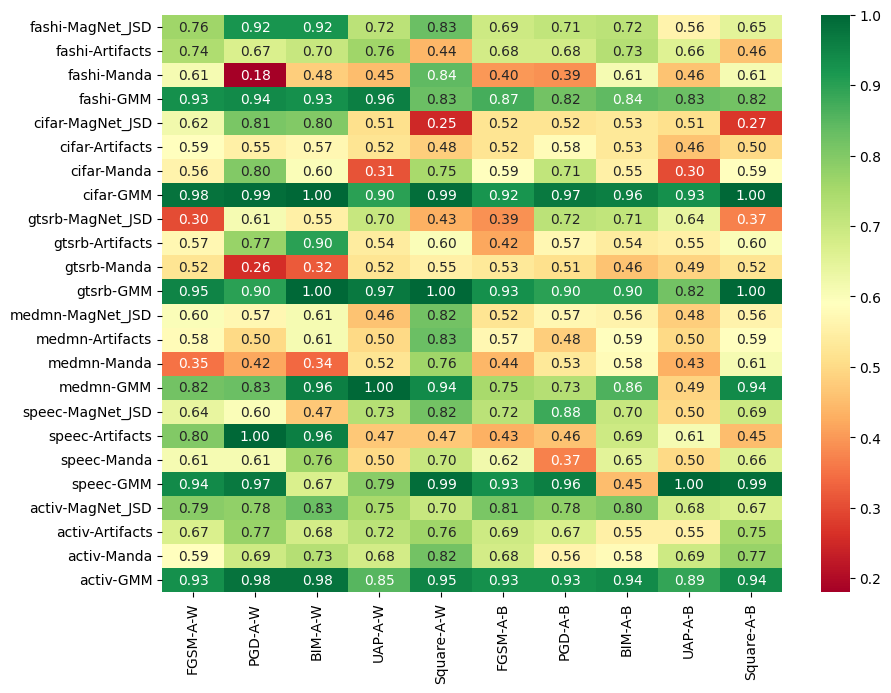

In [11]:
import seaborn as sns
plt.figure(figsize=(10, 7.5))
sns.heatmap(merged_result.astype(float), annot=True, fmt='0.2f', cmap="RdYlGn")
plt.show()

In [12]:
print(df.to_latex())
table_text = df.to_latex()

\begin{tabular}{lllrrllrrrrrrrrlrrrllll}
\toprule
 & Detector & DetType & P_max_ben & P_max_adv & Environment & Attack & AUROC & AUPRC & Precision & Recall & FPR & F1Score & EvalType & Scale & Rep & AeHidLay & AeLatDim & AeNoiFact & BlackBox & Dataset & attack_type & eval_type \\
\midrule
0 & Manda & Manda & 1.000000 & 1.000000 & clean & FGSM & 0.594900 & 0.644900 & 0.594900 & 0.000000 & 0.000000 & 0.000000 & 0 & False & Feat & 4 & 1024 & 0.050000 & White-box & activity & adversarial & All \\
1 & Artifacts & Artifacts & 1.000000 & 1.000000 & clean & FGSM & 0.671400 & 0.735800 & 0.671400 & 0.070000 & 0.000000 & 0.130800 & 0 & False & Feat & 4 & 1024 & 0.050000 & White-box & activity & adversarial & All \\
2 & MagNet_L1 & MagNet & 1.000000 & 1.000000 & clean & FGSM & 0.709000 & 0.713100 & 0.709000 & 0.050000 & 0.000000 & 0.095200 & 0 & False & Feat & 4 & 1024 & 0.050000 & White-box & activity & adversarial & All \\
3 & MagNet_JSD & MagNet & 1.000000 & 1.000000 & clean & FGSM & 0.792300 &

In [13]:
replacements = {
    "fashion": "F-MNIST", 
    "mnist": "MNIST", 
    "cifar10": "CIFAR-10", 
    "gtsrb": "GTSRB", 
    "speech": "Speech", 
    "medmnist" : "Med-MNIST", 
    "MagNet_JSD": "MagNet",
    "activity": "Activity",
    "GMM": "\sysname",
    }


In [14]:
for dataset_ext in list_of_datasets:
    print(rf"\hline\hline")
    print(rf"\multirow{{5}}{{*}}{{\rotatebox{{90}}{{{replacements[dataset_ext]}}}}}")
            # print(dataset_ext)
    for lines in table_text.split("\n"):

        if dataset_ext[0:5] in lines:
            lines=lines.replace(dataset_ext[0:5]+"-", " & ")
            for key, val in replacements.items():
                lines = lines.replace(key, val)
            print(lines)


\hline\hline
\multirow{5}{*}{\rotatebox{90}{F-MNIST}}
\hline\hline
\multirow{5}{*}{\rotatebox{90}{CIFAR-10}}
\hline\hline
\multirow{5}{*}{\rotatebox{90}{GTSRB}}
\hline\hline
\multirow{5}{*}{\rotatebox{90}{Med-MNIST}}
\hline\hline
\multirow{5}{*}{\rotatebox{90}{Speech}}
\hline\hline
\multirow{5}{*}{\rotatebox{90}{Activity}}
0 & Manda & Manda & 1.000000 & 1.000000 & clean & FGSM & 0.594900 & 0.644900 & 0.594900 & 0.000000 & 0.000000 & 0.000000 & 0 & False & Feat & 4 & 1024 & 0.050000 & White-box & Activity & adversarial & All \\
1 & Artifacts & Artifacts & 1.000000 & 1.000000 & clean & FGSM & 0.671400 & 0.735800 & 0.671400 & 0.070000 & 0.000000 & 0.130800 & 0 & False & Feat & 4 & 1024 & 0.050000 & White-box & Activity & adversarial & All \\
2 & MagNet_L1 & MagNet & 1.000000 & 1.000000 & clean & FGSM & 0.709000 & 0.713100 & 0.709000 & 0.050000 & 0.000000 & 0.095200 & 0 & False & Feat & 4 & 1024 & 0.050000 & White-box & Activity & adversarial & All \\
3 & MagNet & MagNet & 1.000000 & 1.000

# Create Attack Data

In [15]:
dataset_dict = {"mnist" : "MNIST",
                "fashion" : "F-MNIST",
                "cifar10" : "CIFAR-10",
                "gtsrb" : "GTSRB",
                "activity" : "Activity",
                "speech" : "Speech",
                "medmnist" : "Med-MNIST",}

In [16]:

df_total = pd.DataFrame([])

for dataset in list_of_datasets:
    for black_box in ['White-box', 'Black-box']:
        print(dataset, black_box)
        result_dir = get_result_dir(dataset)
        detection_dir = f"{result_dir}/data/attack_gen_acc_norm_{black_box}_clean.csv"
        try:
            df = pd.read_csv(detection_dir, index_col=0)
            df['ASR'] = 100 - df['Acc']
            df = df.reset_index(drop=True)
            df['Dataset'] = dataset
            df['Access'] = black_box
            df_total = pd.concat([df_total, df], axis=0)
            # print("File loaded at: ", detection_dir)
        except Exception as e:
            print(e)
        
df_total = df_total.rename(columns={"L2" : "L2 Norm", "Acc" : "Accuracy"})
df_total

fashion White-box
fashion Black-box
cifar10 White-box
cifar10 Black-box
gtsrb White-box
gtsrb Black-box
medmnist White-box
medmnist Black-box
speech White-box
speech Black-box
activity White-box
activity Black-box


,Attack,L2 Norm,Accuracy,ASR,Dataset,Access
0,RN,2.80,96.6,3.4,fashion,White-box
1,FGSM,2.34,35.0,65.0,fashion,White-box
2,BIM,2.02,9.0,91.0,fashion,White-box
3,PGD,2.08,8.0,92.0,fashion,White-box
4,UAP,2.31,49.0,51.0,fashion,White-box
...,...,...,...,...,...,...
1,FGSM,10.59,10.0,90.0,activity,Black-box
2,BIM,8.03,2.0,98.0,activity,Black-box
3,PGD,8.16,2.0,98.0,activity,Black-box
4,UAP,10.59,94.0,6.0,activity,Black-box


In [17]:
df_total = df_total.replace("medmnist", "Med-MNIST")
df_total.replace(dataset_dict, inplace= True)
print(df_total[['ASR', 'Attack', 'Dataset', 'Access']])

     ASR  Attack   Dataset     Access
0    3.4      RN   F-MNIST  White-box
1   65.0    FGSM   F-MNIST  White-box
2   91.0     BIM   F-MNIST  White-box
3   92.0     PGD   F-MNIST  White-box
4   51.0     UAP   F-MNIST  White-box
..   ...     ...       ...        ...
1   90.0    FGSM  Activity  Black-box
2   98.0     BIM  Activity  Black-box
3   98.0     PGD  Activity  Black-box
4    6.0     UAP  Activity  Black-box
5   54.0  Square  Activity  Black-box

[72 rows x 4 columns]


In [18]:
filter_1 = df_total['Attack'] != 'RN'
filter_2 = df_total['Attack'] != 'C&W'
df_total = df_total.where(filter_1 & filter_2).dropna()
df_total

,Attack,L2 Norm,Accuracy,ASR,Dataset,Access
1,FGSM,2.34,35.0,65.0,F-MNIST,White-box
2,BIM,2.02,9.0,91.0,F-MNIST,White-box
3,PGD,2.08,8.0,92.0,F-MNIST,White-box
4,UAP,2.31,49.0,51.0,F-MNIST,White-box
5,Square,4.49,0.0,100.0,F-MNIST,White-box
1,FGSM,2.38,46.0,54.0,F-MNIST,Black-box
2,BIM,2.08,50.0,50.0,F-MNIST,Black-box
3,PGD,2.11,51.0,49.0,F-MNIST,Black-box
4,UAP,2.44,89.0,11.0,F-MNIST,Black-box
5,Square,4.50,49.0,51.0,F-MNIST,Black-box


<Figure size 2000x300 with 0 Axes>

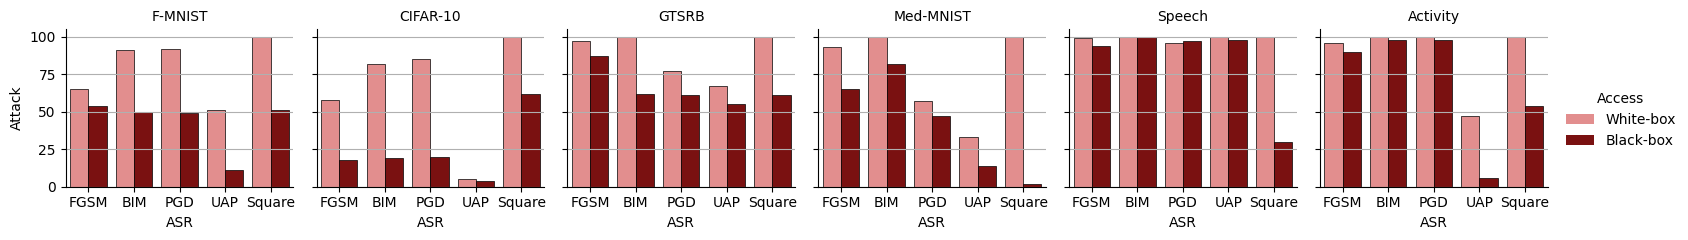

In [19]:
plt.figure(figsize=(20,3))
# g = sns.catplot(data=df_total, col="Dataset", x="Attack", y="ASR", 
#                 hue="Access", hue_order=['White-box', 'Black-box'], 
#                 kind='bar', aspect=1.25, height=2, ci=None)

g = sns.catplot(data=df_total, col="Dataset", x="Attack", y="ASR", 
            hue="Access", hue_order=['White-box', 'Black-box'], 
            kind='bar', aspect=1.05, height=2.50, errorbar=None, 
            # palette={'White-box': 'gray', 'Black-box': 'black'})  # Define colors for each hue
            # palette={'White-box': 'darkblue', 'Black-box': 'lightblue'})
            palette={'White-box': 'lightcoral', 'Black-box': 'darkred'})  # Dark and light red shades

# Add a dark boundary to the bars
for ax in g.axes.flat:  # Iterate over each subplot
    for patch in ax.patches:  # Iterate over each bar
        patch.set_edgecolor('black')  # Set the boundary color
        patch.set_linewidth(0.50)      # Set the boundary thickness

# Add horizontal lines
for ax in g.axes.flat:  # Iterate over each subplot
    ax.yaxis.grid(True)  # Enable horizontal grid lines
    # ax.axhline(0, color='black', linewidth=0.25)  # Optionally add a line at y=0 (x-axis)


g.set_axis_labels("ASR", "Attack")  # Customize axis labels if needed
# g.despine(left=True)  # Remove the left spine
g.set_titles("{col_name}")  # Optional: Title formatting for columns
# g.map(plt.grid, True)  # Enable gridlines


# plt.tight_layout()
plot_dir = Path(f"../artifacts/plots/asr_adversarial_attacks.pdf")
plot_dir.parent.mkdir(exist_ok=True, parents=True)
plt.savefig(plot_dir, dpi = 350)
plt.savefig(plot_dir)
plt.show()

<Figure size 1000x300 with 0 Axes>

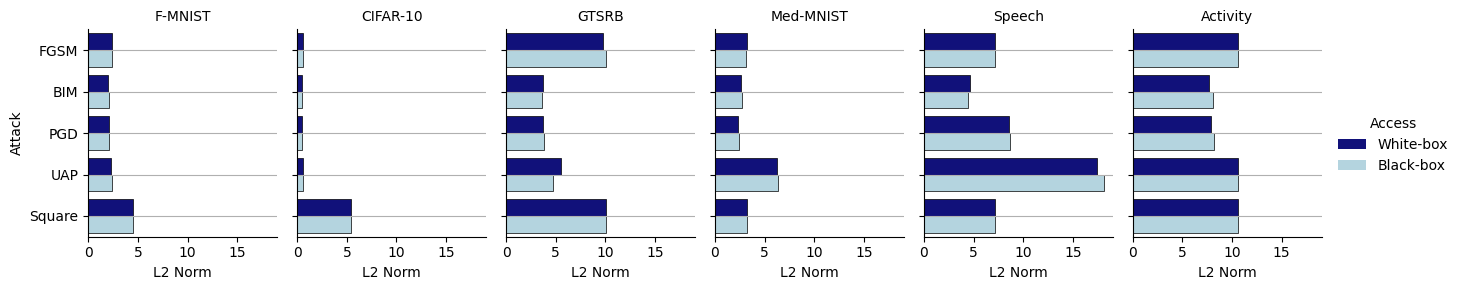

In [20]:
plt.figure(figsize=(10,3))
# g = sns.catplot(data=df_total, col="Dataset", x="Attack", y="ASR", 
#                 hue="Access", hue_order=['White-box', 'Black-box'], 
#                 kind='bar', aspect=1.25, height=2, ci=None)

g = sns.catplot(data=df_total, col="Dataset", y="Attack", x="L2 Norm", 
            hue="Access", hue_order=['White-box', 'Black-box'], 
            kind='bar', aspect=0.75, height=3, errorbar=None, 
            # palette={'White-box': 'gray', 'Black-box': 'black'})  # Define colors for each hue
            palette={'White-box': 'darkblue', 'Black-box': 'lightblue'})
            # palette={'White-box': 'lightcoral', 'Black-box': 'darkred'})  # Dark and light red shades

# Add a dark boundary to the bars
for ax in g.axes.flat:  # Iterate over each subplot
    for patch in ax.patches:  # Iterate over each bar
        patch.set_edgecolor('black')  # Set the boundary color
        patch.set_linewidth(0.50)      # Set the boundary thickness

# Add horizontal lines
for ax in g.axes.flat:  # Iterate over each subplot
    ax.yaxis.grid(True)  # Enable horizontal grid lines
    # ax.axhline(0, color='black', linewidth=0.25)  # Optionally add a line at y=0 (x-axis)


g.set_axis_labels("L2 Norm", "Attack")  # Customize axis labels if needed
# g.despine(left=True)  # Remove the left spine
g.set_titles("{col_name}")  # Optional: Title formatting for columns
# g.map(plt.grid, True)  # Enable gridlines


# plt.tight_layout()
# plt.savefig(f"../artifacts/plots/norm_adversarial_attacks.jpg", dpi = 350)
# plt.savefig(f"../artifacts/plots/norm_adversarial_attacks.pdf")
plot_dir = Path(f"../artifacts/plots/norm_adversarial_attacks.pdf")
plot_dir.parent.mkdir(exist_ok=True, parents=True)
plt.savefig(plot_dir, dpi = 350)
plt.savefig(plot_dir)
plt.show()